# Le modèle de ségrégation de Schelling
L. Rannou (basé sur S. Stinckwich)  
*ARE DYNAMIC - 2021*

## Préambule

En Décembre 2016 disparaissait Thomas C. Schelling. Economiste, récipiendaire du Prix de la Banque de Suède en sciences économiques (communément appelé et considéré comme le prix Nobel d’économie), il a travaillé sur de nombreux sujets, en particulier l’analyse des conflits.

Une de ses contributions a permis de mieux comprendre les phénomènes de ségrégation. Plus précisément, le propos de Schelling fut d’étudier la dynamique par laquelle **des phénomènes de ségrégation extrêmes** peuvent survenir, en dépit de **préférences qui peuvent sembler faiblement discriminantes individuellement**. Ainsi, même si chaque individu se déclare prêt à accepter une certaine proportion d’invidus « différents » dans son voisinage, le résultat final peut être que la population se regroupe en régions très homogènes.

Cette étude peut être menée à l’aide de modèles connus sous le nom d’automates cellulaires. Un des automates les plus célèbres est le [jeu de la vie](https://fr.wikipedia.org/wiki/Jeu_de_la_vie), proposé par John Conway en 1970. Il existe de nombreux autres automates cellulaires dont le comportement est relativement bien étudié, et la littérature est riche à ce sujet. Nous recommandons la lecture de l’article [2] de Jean-Paul Delahaye.

## Objectifs

Dans ce notebook nous allons essayer de modéliser la répartition d'une population humaine sur une aire urbaine (un *monde*). Nous allons essayer de comprendre les différentes formes de ségration et de communautarisme pouvant avoir lieu dans les villes.
Nous partons d'une hypothèse primordiale : **chaque individu est indépendant cependant il ne peut pas se sentir confortable dans un quartier où les habitants sont en majorité "différents" de lui.**

Dans un premier temps nous allons modéliser cette répartition une aire urbaine simple : une rue ou une avenue (modèle linéaire).
Puis dans un second temps nous modéliserons cette répartition à l'échelle d'une ville (modèle spatial).


# 1ère partie : Modèle linéaire

Considérons un monde *linéaire* (c’est en fait le premier modèle étudié par Schelling dans son article [1], à quelques détails près). Le modèle se compose des éléments suivants.

- Les *individus* sont de deux *types* (« 0 » et « 1 »), disposés spatialement sur une ligne de taille $n$ (le *monde*).
- Le *voisinage* d'un *individu* est constitué de ses 8 voisins de part et d'autre de sa cellule (4 à sa gauche et 4 à sa droite). Il faut noter que le nombre de voisins peut varier selon la localisation (pour les individus en bout de ligne).
- Le *seuil de satisfaction* : un *individu* est satisfait si une majorité (faible) de ses voisins est du même *type* que lui (i.e. il veut **au moins** autant de voisins du même *type* que lui que de voisins d'un *type* différent).
- Le *mode de déplacement* : un *individu* non satisfait va chercher à se déplacer pour trouver un emplacement qui le satisfasse (un emplacement dont le *voisinage* respecte son *seuil de satisfaction*). Dans le cas où plusieurs emplacements peuvent le satisfaire, un *individu* se déplace vers l’emplacement le plus proche. Si deux emplacements à la même distance sont satisfaisants l'emplacement de droite est privilégié.
- La *dynamique des déplacements* : tous les individus sont considérés, de gauche à droite. Chaque individu non satisfait **s'insère** à l’emplacement satisfaisant le plus proche. Un *tour* est terminé lorsque tous les agents ont été considérés.


À l'issu d'un *tour* des individus peuvent se retrouver à nouveau insatisfaits, dû aux déplacements de leurs voisins.
Partant d’un état initial, le processus est répété jusqu’à équilibre, c’est-à-dire jusqu’à ce que plus aucun individu insatisfait ne puisse se déplacer, ou qu’une situation de blocage soit détectée. Cela peut nécessiter plusieurs *tours*.

### Example

Pour illustrer le propos, considérons la situation initiale suivante :

![Linear Model 1](linearmodel1.png)

Les individus non satisfaits sont indiqués en gris dans la table. Le premier individu à se déplacer sera donc le deuxième en partant de la gauche. En effet, son voisinage ne comprend qu’un autre individu de type "1" (et 4 de type "0"). Pour trouver une place satisfaisante, il va devoir se déplacer de 6 cases vers la droite (l'emplacement satisfaisant le plus proche).

Le nouvel état du monde sera alors (l’individu s’étant déplacé est en gras):

![Linear Model 2](linearmodel2.png)


### Références
- [1] Thomas C. Schelling, [Dynamic Models of Segregation](http://www.stat.berkeley.edu/~aldous/157/Papers/Schelling_Seg_Models.pdf), Journal of Mathematical Sociology (1971) 143-186
- [2] J.-P. Delahaye, [Le royaume du jeu de la vie](http://www.lifl.fr/~jdelahay/dnalor/Jeudelavie.pdf), Pour la Science (2009) 378

#  Etude du modèle "linéaire"

**Objectifs : implémenter le modèle de Schelling en python, le tester sur un exemple simple puis étudier l'impact que peuvent avoir les paramètres du modèle sur le monde.**

Nous allons étudier l’impact des paramètres du modèle : 
- la taille du voisinage,
- le seuil de satisfaction des individus,
- la configuration initiale,
- les règles de mouvement (le mode de déplacement).

Pour quantifier l'impact de ces paramètres, en plus de l'observation visuelle de l'évolution de notre monde, nous utiliserons les métriques suivantes : 
- le nombre d’individus satisfaits à l’équilibre,
- la taille (moyenne) des regroupements homogènes observés et leur nombre,
- la moyenne sur tous les individus de voisins du même type qu’eux,
- le nombre de tours nécessaires pour arriver à un état stable.

In [105]:
import numpy as np
import random

from matplotlib import pyplot as plt

In [106]:
# Paramètres du modèle Schelling (à modifier, ne pas oublier de réexécuter la cellule)
neigh = 4          # Taille du voisinnage (d'un côté, pour avoir le total faire *2)
threshold = 0.5    # Seuil de satisfaction
max_iter = 5        # Nombre de tours
size = 22           # Taille du monde (n)

Notre monde est représenté par d'une liste de 0 et de 1. Par exemple :

In [107]:
cells11 = [0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]
neigh11 = 4 #voisinage qui sera utilisé pour nos fonctions
threshold11 = 0.5 #seuil de satisfaction qui sera utilisé pour nos fonctions

In [108]:
assert len(cells11) == size

Nous pouvons considérer que ce monde représente une rue, la population de chaque maison étant de type "0" ou "1". 

La fonction ```print_world``` convertit un monde en une chaîne de caractères pour l'afficher à l'écran.

In [109]:
def print_world(cells):
    '''
    '''
    # Signature à compléter
    result = "|"
    for i in cells:
        result += str(i)+"|"
    return result

In [110]:
print_world(cells11)

'|0|1|0|0|0|1|1|0|1|0|0|1|1|1|0|0|1|1|1|1|0|1|'

**Question 1** : Implémenter la fonction ```neighborhood``` qui prend comme paramètres un monde ```cells```, la position ```c``` d'un individu dans le monde et la taille du voisinnage ```neigh``` et retourne une liste contenant le type des voisins d'un individu (**attention aux bords du monde**).

In [111]:
def neighborhood(cells,neigh,c):
    l = []
    for i in range(max(0, c - neigh), min(len(cells), c + neigh+1)):
        if (i!= c):
            l.append(cells[i])

    return l

neighborhood(cells11,neigh11,5)

[1, 0, 0, 0, 1, 0, 1, 0]

**Question 2 :** Implémenter la fonction ```satisfaction_ratio```, prenant comme paramètres un monde ```cells```, la position ```c``` d'un individu dans le monde et la taille du voisinnage ```neigh```, retourne le niveau de satisfaction d'un individu (le pourcentage de ses voisins étant du même type).

In [112]:
#Question 2 :

def satisfaction(cells, neigh, c):
    """
cells: monde ouvert
neigh : taille du voisinage
c : position de l'individu  (en indice Python! Donc le premier élément de cells a pour indice 0, le 2e ->1 ,le 3e ->2...)
c retourne le niveau de satisfaction de c
    """
    good =cells[c]
    vois = neighborhood(cells,neigh,c)
    itgood=0
    for i in vois:
        if i == good:
            itgood=itgood+1
    return (itgood/len(vois))
  
satisfaction(cells11,neigh11,5)

0.375

**Question 3** :  Implémenter la fonction ```is_happy```, prenant comme paramètres un monde ```cells```, la position ```c``` d'un individu dans le monde, la taille du voisinnage ```neigh``` et ```threshold``` son seuil de satisfaction, retourne un booléen indiquant si l'individu à la position ```c``` est satisfait.

In [113]:
#Question 3:

def ishappy(cells,neigh,c, threshold):
    """
cells: monde étudié
neigh : taille du voisinage
c : position de l'individu  (en indice Python! Donc le premier élément de cells a pour indice 0, le 2e ->1 ,le 3e ->2...)
threshold: seuil de satisfaction
décide si l'individu à c est satisfait
    """
    return satisfaction(cells,neigh,c) >= threshold

ishappy(cells11,neigh11,6,threshold11)

False

**Question 4 :** En s'inspirant de la fonction ```print_world```, implémenter la fonction ```print_satisfaction``` une réprésentation graphique de la statisfaction des individus du monde ```cells```.

In [114]:
def print_satisfaction(cells,neigh,threshold):
    """
cells: monde étudié
retourne la satisfaction des individus de cells
    """
    n=neigh
    cell=cells
    
    result = "|"
    for i in range(len(cells)):
        b = ishappy(cells,neigh,i,threshold)
        if b:
            result += "😃"+"|"
        else :
            result += "☹️" +"|"
            
    return result


print_satisfaction(cells11,neigh11,threshold11)

'|😃|☹️|😃|😃|😃|☹️|☹️|😃|😃|☹️|☹️|☹️|😃|😃|☹️|☹️|😃|😃|😃|😃|☹️|😃|'

**Question 5 :** Implémenter la fonction ```relocation``` **retirant** un individu à la position ```c``` et l'**insérant** juste avant la position```d``` (avec $0\leq d \leq n$). **Cette fonction doit retourner une copie du monde**.

In [115]:
def relocation(cells,c,d):
    """
cells : monde étudié
c : position de l'individu

d : position de référence pour la nouvelle position de l'individu 
(ici on place notre individu à la position d-1)
on a 0 <= d <= n
    """
    #Il faut copier la liste avant de la modifier :
    newcells = cells.copy()
    
    #l.pop(c) retire l'élément à la position c et le renvoie (ici dans i)
    i=newcells.pop(c)
    
    #l.insert(d, c) insère l'élément c à la position d
    newcells.insert(d,i)
    return newcells

cells11
    

[0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]

In [116]:
relocation(cells11,6,2)

[0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]

**Question 6 :** Implémenter la fonction ```nearest_satisfying``` qui, pour un individu insatisfait, retourne la position satisfaisante la plus proche (en cas d'égalité : préférer la position satisfaisante de droite).  
*Indice :* Pour savoir si une position est satisfaisante nous pouvons essayer d'insérer l'individu et lui demander s'il est satisfait de son nouveau voisinnage.

In [117]:
def nearest_satisfaying(cells,neigh,c,threshold):
    """
cells : monde étudié
c : position de l'individu
    """
    if ishappy(cells,neigh,c,threshold):
        return "Déja heureux"
    
    satis2=0
    for i in range(c+1,len(cells)):
        test1= relocation(cells,c,i)
        #e = c-(d-c)
        if ishappy(test1,neigh,i,threshold):
            satis1 = i
            
            for a in range(0,c):
                test2= relocation(cells,c,a)
                if ishappy(test2,neigh,a,threshold):
                    satis2=a
                    
            if satis2==0:
                return satis1
            if (abs(c- satis2))==(abs(satis1-c)):
                return satis1
            elif (abs(c- satis2))>(abs(satis1-c)):
                return satis1
            else:
                return satis2
    
    return c

nearest_satisfaying(cells11,neigh11,6,threshold11)


8

### Dynamique

La dynamique consiste à répéter les déplacements. Schelling suggère de considérer les individus un par un, en partant de la gauche, et de les faire se déplacer s'ils le peuvent. Un *tour* est terminé lorsque tous les individus ont été considérés, et on peut répéter ainsi les tours. Mais quand s'arrêter avec cette dynamique ? 

Nous considérons différents critères de convergence :
* Lorsque tous les individus sont satisfaits. Cependant, rien ne garantit que le système puisse parvenir à un état où tous les individus sont satisfaits (cela peut arriver mais c'est plutôt exceptionnel). 
* Lorsque plus aucun individu ne peut se déplacer. Ce critère est plus pertinent, mais il cache une difficulté: le système ne parvient pas non plus nécessairement dans un état où plus aucun individu ne peut se déplacer. Ce critère seul peut donc mener à des boucles infinies.
* Nous emploierons donc un garde-fou, qui consistera à poser un nombre maximal d'itérations. Si le système n'est pas stabilisé, selon le critère précédent, après ce nombre d'itérations : la dynamique s'arrête. 

**Question 7**: Implémenter la fonction ```schelling``` qui effectue un *tour* du modèle de schelling. Vérifier l'exactitude de cette fonction sur des exemples de votre choix (papier et stylo utiles). 

In [118]:
def schelling(cells,neigh,threshold):
    """
    cells : monde étudié
    neigh: taille du voisinage utilisé
    threshold : seuil de satisfaction pour lequel une personne est satisfaite (en général 50)
    """
    #liste finale (qui commence par (= cells) avant d'être modifiée):
    liste=cells
    
    #parcours du monde étudié
    for i in range(len(cells)):
        if not ishappy(cells,neigh,i,threshold):
            #changement de place :
            anc_place = i
            place = nearest_satisfaying(cells,neigh,i,threshold)
            l=liste
            liste = relocation(l,anc_place,place)  
            
    #affiche la satisfaction de chacun des individus de la nouvelle liste
    return liste

#Jeux de tests perso:
liste1 = schelling(cells11,neigh11,threshold11)
liste2 = schelling(liste1,neigh11,threshold11)
liste3 = schelling(liste2,neigh11,threshold11)
liste4 = schelling(liste3,neigh11,threshold11)

print_satisfaction(liste4,neigh11,threshold11)

liste3==liste2
liste1
#liste4==liste3
#liste4==liste5
#au bout de deux tours le monde n'évolue plus

[0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]

In [119]:
cells11

[0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]

**Question 8 :** Implementer la fonction finale du modèle de schelling ```linear_schelling``` prenant en compte tous les paramètres du modèle (taille du voisinnage ```neigh```, seuil de satisfaction ```threshold```, nombre d'itérations ```max_iter```).

In [120]:
def linear_schelling(cells,neigh,threshold,max_iter):
    """
    cells : monde étudié
    neigh : taille du voisinage
    threshold : seuil de satisfaction
    max_iter : nombre max d'itérations de l'étude
    
    Retourne la liste finale : 
    -> Soit celle qui ne bouge plus 
    -> Soit celle où tous les individus sont satisfaits
    -> Soit celle produite à la <max_iter> itération
    """
    liste = cells
    liste2 = []
    #tours de Schéling "max_iter" fois:
    for i in range(max_iter):
        liste = schelling(liste,neigh,threshold)
        
        #si la liste bouge plus et vaut la précédente (soit l2), on renvoie la satisfaction de la nvelle liste
        if liste2== liste:
            print_satisfaction(liste,neigh,threshold)
            return liste
        #sinon liste2 =liste
        else :
            liste2  = liste
            
        #si tous les individus sont satisfaits, on arrête 
        
        bo2=True #si un seul individu est insatisfait, bo2 devient faux pour toujours
        
        for e in range(len(liste)):
            bo =ishappy(liste,neigh,e,threshold)
            if bo==False:
                bo2=False
                
        #Si bo2 est vrai alors bo2 n'a jamais été faux et les individus sont tous 
        if bo2==True:
            print_satisfaction(liste,neigh,threshold)
            return liste
        
    return liste
            
linear_schelling(cells11,neigh11,threshold11,6)

[0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]

In [121]:
schelling(cells11,neigh11,threshold11)

[0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]

Normalement, à ce stade, nous avons réussi à implémenter le modèle de Schelling sur un monde linéaire. Nous allons, maintenant, essayer de déterminer l'impact des paramètres sur la dynamique de notre *monde*. Pour se faire nous allons avoir besoin de mondes plus grands et d'un nombre de types d'individu plus grand que 2.

**Question 9** : Proposer une méthode pour générer des mondes linéaires de manière automatique et aléatoire (refléchir aux paramètres de cette méthode). Implémenter cette méthode dans la fonction ```generate_linear_world```.  
*Indice*: on peut s'intéresser à la fonction ```c``` du package ```numpy```. 

In [122]:
import numpy as np

def generate_linear_world(long,n):
    """
    Retourne un monde linéaire aléatoire de longueur long composé de n types.
    """
    liste=[]
    for e in range(long):
        alea = np.random.choice(n)
        liste.append(alea)
    return liste

generate_linear_world(22,2)

[0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1]

La fonction ```plot_world``` permet d'afficher notre monde de manière un peu plus élégante:

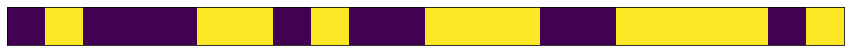

In [123]:
def plot_world(world):
    if type(world) == list:
        A = np.array([world])
    else:
        A = world
    plt.figure(figsize=(15,12)) # (30,30) = Taille de la figure
    plt.imshow(A,cmap='viridis')
    plt.tick_params(top=False, bottom=False, right=False, left=False, labelleft=False, labelbottom=False)
    plt.show()
    
plot_world(cells11)    

**Question 10** : Implémenter les métriques suivantes (une métrique = une fonction) :
- ```happiness_rate``` le ratio d’individus satisfaits,
- ```mean_size_communities``` la taille (moyenne) des regroupements homogènes observés,
- ```nb_communities``` le nombre de regroupements homogènes,
- ```mean_same_type``` la moyenne sur tous les individus du ratio de voisins du même type qu’eux,
- ```nb_iter_to_stability``` le nombre de tours nécessaires pour arriver à un état stable.

In [124]:
def happiness_rate(cells,neigh,threshold):
    """
    cells : monde étudié
    neigh: taille du voisinage utilisé
    threshold : seuil de satisfaction pour lequel une personne est satisfaite (en général 50)
    renvoie le ratio d'individus satisfaits
    """
    #nombre de personnes satisfaites
    total=0
    
    #parcours du monde étudié
    for i in range(len(cells)):
        if ishappy(cells,neigh,i,threshold):
            total=total+1
            
    return total/len(cells)

happiness_rate(cells11,neigh11,threshold11)

0.5909090909090909

In [125]:
def mean_size_communities(cells):
    """
    cells:monde étudié
    renvoie la taille moyenne des regroupements homogène du monde <cells>.
    On divise donc la somme des tailles de chaque groupe (donc len(cells)) par le nombre de groupes
    """
    pre=cells[0]
    
    #groupes stocke le nombre de groupe
    groupes=1
    
    for i in cells[1:len(cells)+1]:
        
        #si l'élement est comme le précédent alors on est toujours dans le même groupe
        if i==pre:
            pre=i
            
        #si l'élément courant est différent du précédent, alors on est sur un nv groupe
        #le nv groupe est ajouté au nombre de groupes
        else:
            groupes=groupes +1
            pre=i
            
    return (len(cells)/groupes)


#j'ai testé avec un autre monde où il y a 4 types d'individus et ca fonctionne aussi:
cells2 = [1,2,3,3,3,4,1,1,2,2] 
mean_size_communities(cells2)==(10/6)


mean_size_communities(cells11)

1.8333333333333333

In [126]:
def nb_communities(cells):
    """
    cells:monde étudié
    Renvoie le nombre de groupement homogène: 
    je définis ici un groupement homogène <gr> comme un voisinage de len(<gr>) individus 
    qui ont le même type. 
    """
    pre=cells[0]
    groupes=1
    for i in cells[1:len(cells)+1]:
        if i==pre:
            pre=i
        else:
            groupes=groupes +1
            pre=i
            
    return groupes

nb_communities(cells11)

12

In [127]:
def mean_same_type(cells, neigh):
    """
cells: monde ouvert
neigh : taille du voisinage
retourne la moyenne sur tous les individus du ratio de voisins du même type qu’eux,
    """
    ratio2 = 0
    for i in cells:
        good =cells[i]
        vois = neighborhood(cells,neigh,i)
        itgood=0 #nombre de voisins de même type
        for e in vois:
            if e == good:
                itgood=itgood+1
                
        ratio = itgood/len(vois) #ratio de voisins de même type
        ratio2 = ratio2+ratio #somme des ratios
    
    return ratio2/len(cells)


mean_same_type(cells11,neigh11)

0.44999999999999996

In [128]:
def nb_iter_to_stability(cells,neigh,threshold,limit):
    """
    cells : monde étudié
    neigh : taille du voisinage
    threshold : seuil de satisfaction
    limit : garde-fou
    
    Retourne le nombre d'itérations nécéssaires pour un état stable, donc:
    -> Soit la liste qui ne bouge plus 
    -> Soit la liste où tous les individus sont satisfaits
    Si cet etat stable n'arrive jamais, on retournera la limite fixée du nombre de tours à faire
    """
    liste = cells
    liste2 = []
    iteration=0
    
    #tours de Schéling <limit> fois:
    while iteration<limit:
        
        liste = schelling(liste,neigh,threshold)
        
        #si la liste bouge plus et vaut la précédente (soit l2), on renvoie iteration
        if liste2== liste:
            print_satisfaction(liste,neigh,threshold)
            return iteration
        #sinon liste2 =liste
        else :
            liste2  = liste
            
        #si tous les individus sont satisfaits, on arrête et on renvoie iteration
        
        bo2=True #si un seul individu est insatisfait, bo2 devient faux pour toujours dans cette iteration
        
        for e in range(len(liste)):
            bo =ishappy(liste,neigh,e,threshold)
            if bo==False:
                bo2=False
                
        #Si bo2 est vrai alors bo2 n'a jamais été faux et les individus sont tous satisfaits
        if bo2==True:
            print_satisfaction(liste,neigh,threshold)
            return iteration
        
        iteration = iteration +1
        
    return iteration

nb_iter_to_stability(cells11,neigh11,threshold11,10)

2

**Question 11 :** Faire varier les paramètres du modèle et observer l'évolution des différentes métriques. Tracer les courbes correspondantes, si elles sont judicieuses, en utilisant matplotlib ; puis décrire les phénomènes observés (pas plus de 3 courbes, un paragraphe par phénomène observé).

*Indices :* Tracer l'évolution du taux de satisfaction au fil des tours. Faire évoluer le seuil de satisfaction par pas de 0.1 de 0 à 1. Etudier la taille des regroupements homogènes en fonction de ce seuil. Nombre de tours nécessaires pour arriver à un état stable en fonction de la taille du monde. 

=======================================

- Courbe 1: 
c'est la représentation graphique du taux de satisfaction au fil des tours.
- Dans la cellule ci-dessus, je vais donc créer une fonction qui à chaque n tour, associe le taux de satisfaction du monde crée au n-ième tour

=======================================


In [130]:
def taux_tours(cells,neigh,threshold,tours):
    """
    tours: nombre de tours à faire
    retourne la liste des taux de satisfaction de chaque modèle crée à chaque itération
    Il y a <tours> itérations
    """
    
    #liste des <tours> tours 
    liste_x=[k for k in range(0, tours+1)] 
    
    #CREATION DE LA LISTE DES TAUX DE SATISFACTION pour chaque tour
    liste1 = cells
    taux=[happiness_rate(cells11,neigh,threshold)]
    
    for e in range(tours):
        liste1 = schelling(liste1,neigh,threshold) #modèle à la <e>-ième itération
        satis1= happiness_rate(liste1,neigh,threshold)#taux de satisfaction de liste2
        taux.append(satis1) #liste des taux de satisfaction
        
    return (liste_x,taux)

cells3= generate_linear_world(22,2)
taux_tours(cells3,neigh11,threshold11,6)


([0, 1, 2, 3, 4, 5, 6],
 [0.5909090909090909,
  0.7272727272727273,
  0.8636363636363636,
  0.8636363636363636,
  0.8636363636363636,
  0.8636363636363636,
  0.8636363636363636])

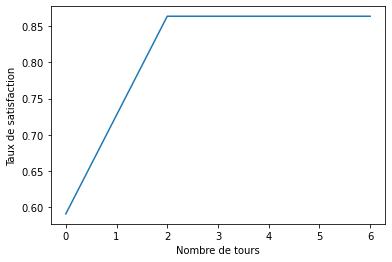

Représentation graphique de l'évolution du taux de satisfaction au fil des tours.


In [131]:
#CREATION DE LA COURBE 1:
#on utilisera ici 6 tours et les valeurs de <cells11>, <threshold> et <neigh11>, définies bien plus haut

%matplotlib inline
import matplotlib.pyplot as plt

X,Y= taux_tours(cells3,neigh11,threshold11,6)

plt.plot(X,Y)
plt.xlabel("Nombre de tours")
plt.ylabel("Taux de satisfaction")
plt.show()

print("Représentation graphique de l'évolution du taux de satisfaction au fil des tours.")

=======================================

BILAN de la Courbe 1 :
- Entre le monde original et le 1e tour, le taux de satisfaction augmente bien d'environ 10% (de 60 à 70%). 
- Entre le 1e et le 2e tour, le taux de satisfaction augmente encore de 10% (de 70 à 80)
- A partir du 2e tour, le taux de satisfaction n'évolue plus ; on sait déja que un "état stable" est atteint puisque à chaque tour, le monde n'évolue plus.
- Les déplacements effecctués pour satisfaire les individus fonctionnent donc bien : le taux de satisfaction du monde passe de 60% à 80%.

=======================================

=======================================

COURBE 2 : 
- Cette courbe est la représentation graphique de l'évolution de la taille des regroupements homogènes dans un monde en fonction du seuil de satisfaction des individus. 
- Chaque monde étudié sera donc un monde aléatoire ayant subi un tour de SCHELLING dont on fera varier le seuil de satisfaction des individus.
- Cette courbe permettra d'étudier l'influence de la tolérance de chaque individu sur leur regroupements/séparation ; donc par exemple,retrouverons-nous une forte ségrégation entre les individus différents lorsque ceux-ci sont très peu tolérants ?
- Plus les regroupements homogènes sont grands, plus les individus similaires sont regroupés.

=======================================

In [139]:
def taille_seuil(cells,neigh):
    """
    Retourne la liste des tailles moyennes des regroupements homogènes des mondes créés avec un tour de Schelling pour 
    lequel, pour chaque monde, le seuil de satisfaction <threshold> aura évolué de 0.1 à 1
    
    """
    liste_seuil=[(k/10) for k in range(0, 10)]
    liste_seuil.append(1)
    somme= []
    cells=generate_linear_world(300,2)
    for e in liste_seuil:
        world=schelling(cells,neigh,e)
        taille=mean_size_communities(world)
        somme.append(taille)
        
    return (liste_seuil,somme)

taille_seuil(cells11,neigh11)

([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 [1.829268292682927,
  1.829268292682927,
  1.8072289156626506,
  2.0547945205479454,
  2.830188679245283,
  2.7777777777777777,
  2.1739130434782608,
  2.1739130434782608,
  1.9736842105263157,
  1.829268292682927,
  1.829268292682927])

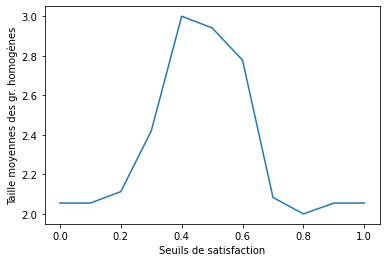

Evolution de la taille des regroupements homogènes en fonction du seuil de satisfaction des individus.


In [140]:
#CREATION DE LA COURBE 2:
#on utilisera les valeurs de <cells11> et <neigh11>, définies bien plus haut

%matplotlib inline
import matplotlib.pyplot as plt

x1,y1= taille_seuil(cells11,neigh11)

plt.plot(x1,y1)
plt.xlabel("Seuils de satisfaction")
plt.ylabel("Taille moyennes des gr. homogènes")
plt.show()

print("Evolution de la taille des regroupements homogènes en fonction du seuil de satisfaction des individus.")

=======================================

BILAN - Courbe 2:

- On a utilisé ici un monde aléatoire très grand (taille = 300). On peut refaire l'expérience avec plusieurs mondes aléatoires en ré-executant à chaque fois les cellulles précédentes. 
- On remarque bien que quelque soit la courbe crée, un pic est observable pour un seuil situé dans l'intervalle [0.4:0.6], soit pour un seuil de 50%.
- Aux extrémités de l'intervalle des seuils de satisfactions (donc quand le seuil vaut 0.1 et 0.9 par exxemple),le taille moyenne des groupements homogène dans le monde est réduite comparé à ce fameux pic.
- On en conclut donc que lorsque le seuil de satisfaction est trop faible, ou trop élevé, les ségrégations sont bien moins marquées. Les groupes homogènes sont plus petits, en somme.
- En revanche, lorsque le seuil est équilibré autour de 50%, les groupements sont plus grands ; les ségrégations sont plus marqués.

=======================================

=========================================================

Courbe 3 :
- Elle représente l'évolution du nombre de tours nécessaires pour arriver à un état stable en fonction de la taille du monde. 
- Permettra de voir si la taille d'une population influe sur le nombre de tours pour l'état stable

========================================================

In [141]:
def tours_taille(cells,neigh,threshold,taille):
    """
    retourne une liste du nombre de tours nécessaires pour arriver à un état stable 
    pour <taille> mondes de tailles différentes.
    On prendra 10 pour la taille minimale d'un monde donc taille >= 10
    On fixera un garde fou du nombre d'itérations à 20.
    """
    #tailles des mondes
    listex=[k for k in range(10,taille+1)]#finalement ne sert plus à grand chose, mais on garde on sais jms
    tours=[]##finalement ne sert plus à grand chose, mais on garde on sais jms
    
    liste2=[10, 25, 50, 100, 150,200]
    for e in liste2:
        liste1 = generate_linear_world(e,2)#crée une liste aléatoire de longueur e 
        nb_iter = nb_iter_to_stability(liste1,neigh,threshold,20)
        tours.append(nb_iter)#conserve le nombre de tours de chaque liste aléatoire dont la taille augmente
        
    return (liste2,tours)

tours_taille(cells11,neigh11,threshold11,500)

([10, 25, 50, 100, 150, 200], [1, 3, 2, 5, 6, 7])

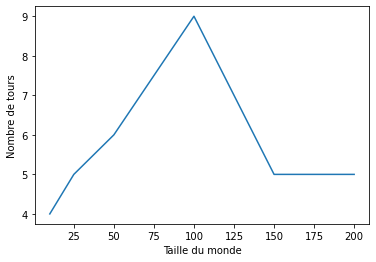

évolution du nombre de tours nécessaires pour arriver à un état stable en fonction de la taille du monde


In [142]:
#CREATION DE LA COURBE 3:
#on utilisera les valeurs de <cells11>,<threshold11> et <neigh11>, définies bien plus haut

%matplotlib inline
import matplotlib.pyplot as plt

x2,y2= tours_taille(cells11,neigh11,threshold11,200)

plt.plot(x2,y2)
plt.xlabel("Taille du monde")
plt.ylabel("Nombre de tours")
plt.show()

print("évolution du nombre de tours nécessaires pour arriver à un état stable en fonction de la taille du monde")

=========================================================

BILAN - COURBE 3 :

- Pour celle-ci, je n'ai pas vraiment d'explications, chaque monde donne une courbe différente :(
- A moins que ce soit normal et qu'il n'est pas censé y avoir de relation logique ?

- Je remarque que néanmoins, le nombre de tours est parfois centré autour de 8.

=========================================================
    

# 2ème partie : Modèle spatial

Dans cette partie le monde que nous allons considérer n'est plus constitué d'une dimension mais de deux dimensions. Si l'on pouvait assimiler le modèle "linéaire" à l'application du modèle de Schelling dans une rue, l'extension à une deuxième dimension permet de modéliser le modèle de Schelling à l'échelle d'une ville (pensons à une carte divisées en emplacements carrés de même taille, chaque carré représentant un immeuble ou un pâté de maisons).

Un emplacement est déterminé par ses coordonnées $(X,Y)$. Par exemple, l'emplacement $(0,0)$ est situé en tout en haut à gauche et l'emplacement $(n,m)$ tout en bas à droite.

L’extension du modèle linéaire au modèle spatial n’est pas triviale. En effet, si toutes les localisations sont occupées, il n’est pas si évident de définir les règles de déplacements (où se déplacent les individus « chassés » de leur localisation ?).

Il est alors plus aisé d’introduire des localisations non occupées. Dans ce cas, les individus non satisfait se déplacent au hasard vers une localisation inoccupée. Contrairement au modèle linéaire, la nouvelle localisation ne satisfait pas forcément le seuil de préférence et n'est pas forcément la plus proche (ces alternatives pourront être implantées en question 5).

# Etude du modèle spatial

In [143]:
# Paramètres du modèle Schelling (à modifier, ne pas oublier de réexécuter la cellule)
neigh = 1       # Taille du voisinnage
threshold = 0.5 # Seuil de satisfaction
max_iter = 5    # Nombre de tours
n,m = 7,7       # Taille du monde (n)

**Question 1** : Implanter la fonction ```generate_spatial_world``` permettant de générer des mondes spatiaux aléatoirement (de même : s'interroger sur les paramètres nécessaires). Utiliser ```numpy.array```.  
*Indice* : Pour un emplacement innocupé, nous pouvons créer un nouveau type.

In [144]:
def generate_spatial_world(larg,long):
    """
    Retourne des mondes spatiaux aléatoirement
    """
    B = np.zeros((larg, long))
    for n in range(larg):
        for m in range(long):
            B[n,m]=np.random.choice(3)
    return B
        
generate_spatial_world(7,7)

#Les emplacements avec des 2 sont considérés vides.

array([[2., 2., 1., 1., 0., 0., 1.],
       [2., 1., 2., 0., 2., 1., 0.],
       [1., 0., 2., 0., 1., 0., 2.],
       [0., 2., 1., 0., 0., 0., 2.],
       [0., 1., 2., 1., 2., 0., 1.],
       [1., 1., 1., 2., 2., 1., 1.],
       [2., 0., 2., 1., 0., 2., 2.]])

**Question 2 :** Implémenter la fonction ```spatial_schelling```, permettant d'appliquer le modèle de schelling sur un monde spatial.  
**Utiliser la [distance de Tchebychev](https://fr.wikipedia.org/wiki/Distance_de_Tchebychev)** dès qu'il est question de comparer des distances entre individus : pour les voisins nous pouvons considérer tous les emplacements dont la distance est inférieure ou égale à ```neigh```.

==========================================================

La méthode d'implémentation de la fonction spatiale sera similaire que celle pour la fonction linéaire

1) regarder l'entourage d'individu (vers le haut mais aussi vers le bas et en biais). Un individu [c,c] aura un entourage [c-1,c], [c,c-1], [c,c+1] etc... Il aura (pour un voisinage neigh=1), entre 3 et 8 voisins. On peut aussi lister ses voisins avec la distance de Tchebychev (=> tous ceux dont la distance est inférieure à neigh sont voisins)

2) Il faudra donc quand on aura listé tous ces voisins, compter ceux qui sont pareil que l'individu

3) déterminer avec threshold s'il est heureux où non.

4) le déplacer s'il est malheureux dans une case vide au hasard QUI LE REND SATISFAIT (donc celles avec un 2). On parcourera par exemple le monde et la 1ere case "2" satisfaisante pour notre individu (il faudra tester cette case) sera la gagnante. S'il y en a pas, l'individu bouge pas.
    
3) Finalement, on recommence les étapes 1) 2) 3) et 4) pour chaque individu jusqu'à la fin du monde

===========================================================

**Question 3 :** Adapter les métriques de la question 10 pour le modèle spatial. 

**Question 4 :** Faire varier les paramètres du modèle et observer l'évolution des différentes métriques. Tracer les courbes correspondantes, si elles sont judicieuses, en utilisant matplotlib ; puis décrire les phénomènes observés (pas plus de 3 courbes, un paragraphe par phénomène observé).  

**Question 5 (optionnelle) :** Proposer des alternatives au modèle.  

# 3ème partie : Animation (Interface Graphique avec tkinter)

In [138]:
import tkinter as Tk